# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
    #  Note the difference between (0.1307) and (0.1307,)
])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# MPS?
mps = torch.backends.mps.is_available()
print("MPS Available?", mps)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
elif mps:
    torch.mps.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda or mps else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False
MPS Available? True


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

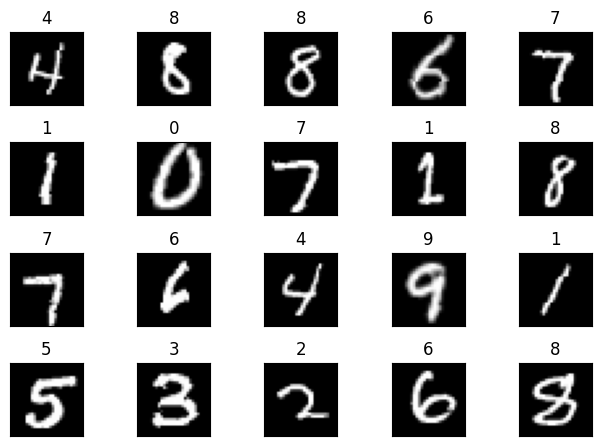

In [5]:
from utils import return_dataset_images

return_dataset_images(train_loader, 20)


# The model
Let's start with the model we first saw

In [6]:
use_cuda = torch.cuda.is_available()
use_mps = torch.backends.mps.is_available()
device = torch.device("cuda" if use_cuda else "mps" if use_mps else "cpu")
device

device(type='mps')

In [7]:
from model import Model_2_1

model = Model_2_1(device).to(device)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
from model import model_summary
model_summary(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 10, 24, 24]             910
              ReLU-5           [-1, 10, 24, 24]               0
       BatchNorm2d-6           [-1, 10, 24, 24]              20
            Conv2d-7           [-1, 20, 22, 22]           1,820
              ReLU-8           [-1, 20, 22, 22]               0
       BatchNorm2d-9           [-1, 20, 22, 22]              40
        MaxPool2d-10           [-1, 20, 11, 11]               0
           Conv2d-11           [-1, 10, 11, 11]             210
      BatchNorm2d-12           [-1, 10, 11, 11]              20
           Conv2d-13             [-1, 10, 9, 9]             910
             ReLU-14             [-1, 1

# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [9]:
from model import model_train, model_test

# Let's Train and test our model

### Block 1 : Model_2_1
##### Target:

1- Added image augmentation. Random crop, rotation and image normalization.


#### Results:
1- Parameters: 7960

2- Best Training Accuracy: 99.29

3- Best Test Accuracy: 99.41

#### Analysis:

2- After adding image augm,entation and stepLR I was able to achive 99.4 consistently in last 3/4 epochs.

In [10]:
model = Model_2_1(device).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)

criterion = F.nll_loss

for epoch in range(1, 16):
    print("Epoch ", epoch)
    model_train(model, device, train_loader, optimizer, criterion)
    model_test(model, device, test_loader, criterion)
    scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch  1


Train: Loss=0.0363 Batch_id=468 Accuracy=90.70: 100%|██████████| 469/469 [00:08<00:00, 53.71it/s]



Test set: Average loss: 0.0739, Accuracy: 9763/10000 (97.63%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch  2


Train: Loss=0.0805 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:08<00:00, 58.35it/s]



Test set: Average loss: 0.0446, Accuracy: 9855/10000 (98.55%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch  3


Train: Loss=0.0894 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:07<00:00, 59.38it/s]



Test set: Average loss: 0.0419, Accuracy: 9871/10000 (98.71%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch  4


Train: Loss=0.0657 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:07<00:00, 59.33it/s]



Test set: Average loss: 0.0339, Accuracy: 9891/10000 (98.91%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch  5


Train: Loss=0.1099 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:07<00:00, 59.14it/s]



Test set: Average loss: 0.0417, Accuracy: 9872/10000 (98.72%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch  6


Train: Loss=0.0038 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:07<00:00, 58.97it/s]



Test set: Average loss: 0.0300, Accuracy: 9906/10000 (99.06%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch  7


Train: Loss=0.0799 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:07<00:00, 59.56it/s]



Test set: Average loss: 0.0277, Accuracy: 9914/10000 (99.14%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch  8


Train: Loss=0.0166 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:08<00:00, 58.53it/s]



Test set: Average loss: 0.0289, Accuracy: 9912/10000 (99.12%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch  9


Train: Loss=0.0712 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:08<00:00, 54.86it/s]



Test set: Average loss: 0.0273, Accuracy: 9921/10000 (99.21%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch  10


Train: Loss=0.0101 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:07<00:00, 59.00it/s]



Test set: Average loss: 0.0247, Accuracy: 9926/10000 (99.26%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch  11


Train: Loss=0.0046 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:07<00:00, 58.96it/s]



Test set: Average loss: 0.0218, Accuracy: 9936/10000 (99.36%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch  12


Train: Loss=0.0069 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:08<00:00, 58.62it/s]



Test set: Average loss: 0.0215, Accuracy: 9940/10000 (99.40%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch  13


Train: Loss=0.0083 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:07<00:00, 59.05it/s]



Test set: Average loss: 0.0209, Accuracy: 9941/10000 (99.41%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch  14


Train: Loss=0.0291 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:07<00:00, 59.22it/s]



Test set: Average loss: 0.0211, Accuracy: 9939/10000 (99.39%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch  15


Train: Loss=0.0098 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:07<00:00, 59.60it/s]



Test set: Average loss: 0.0210, Accuracy: 9941/10000 (99.41%)

Adjusting learning rate of group 0 to 1.0000e-03.


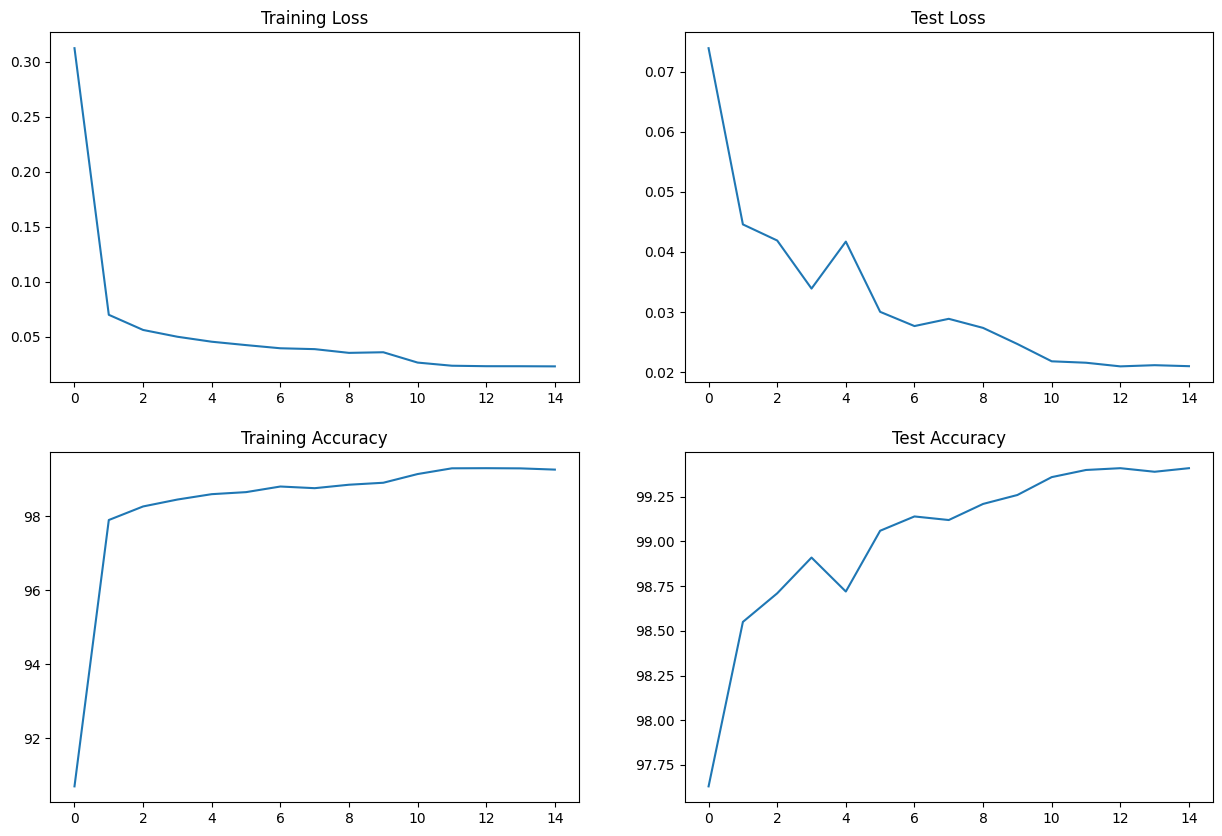

In [11]:
from model import draw_graphs

draw_graphs()